In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import random
import time
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import pickle

In [72]:
train_images = np.load('quickdraw_subset_np/train_images.npy')
train_labels = np.load('quickdraw_subset_np/train_labels.npy')
test_images = np.load('quickdraw_subset_np/test_images.npy')
test_labels = np.load('quickdraw_subset_np/test_labels.npy')

print(train_images.shape) # (20000, 28, 28)
print(test_images.shape) # (5000, 28, 28)

(20000, 28, 28)
(5000, 28, 28)


In [73]:
train_images = train_images.reshape(-1, 784).astype(np.float32) / 255.0
test_images = test_images.reshape(-1, 784).astype(np.float32) / 255.0

val_images = train_images[:2000]
val_labels = train_labels[:2000]
train_images = train_images[2000:]
train_labels = train_labels[2000:]

print(train_images.shape) # (20000, 784)
print(test_images.shape) # (5000, 784)

(18000, 784)
(5000, 784)


In [74]:
print(np.unique(val_labels, return_counts=True))
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([0, 1, 2, 3, 4]), array([397, 379, 398, 410, 416]))
(array([0, 1, 2, 3, 4]), array([3603, 3621, 3602, 3590, 3584]))
(array([0, 1, 2, 3, 4]), array([1000, 1000, 1000, 1000, 1000]))


In [75]:
train_loader = DataLoader(list(zip(train_images, train_labels)), batch_size=64, shuffle=True)
validation_loader = DataLoader(list(zip(val_images, val_labels)), batch_size=64, shuffle=False)
test_loader = DataLoader(list(zip(test_images, test_labels)), batch_size=64, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
    def load_weights(self, weights):
        self.fc1.weight = nn.Parameter(torch.tensor(weights[0], dtype=torch.float32))
        self.fc1.bias = nn.Parameter(torch.tensor(weights[1].flatten(), dtype=torch.float32))
        self.fc2.weight = nn.Parameter(torch.tensor(weights[2], dtype=torch.float32))
        self.fc2.bias = nn.Parameter(torch.tensor(weights[3].flatten(), dtype=torch.float32))
        self.fc3.weight = nn.Parameter(torch.tensor(weights[4], dtype=torch.float32))
        self.fc3.bias = nn.Parameter(torch.tensor(weights[5].flatten(), dtype=torch.float32))

    def save_weights(self):
        w1 = self.fc1.weight.detach().numpy()
        b1 = self.fc1.bias.detach().numpy().reshape(-1, 1)
        w2 = self.fc2.weight.detach().numpy()
        b2 = self.fc2.bias.detach().numpy().reshape(-1, 1)
        w3 = self.fc3.weight.detach().numpy()
        b3 = self.fc3.bias.detach().numpy().reshape(-1, 1)
        return [w1, b1, w2, b2, w3, b3]

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.save_weights(), f)

    def save_model_from_weights(self, weights, filename):
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)
        print("Model weights saved successfully.")
        return weights


    def load_model(self, filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)
        self.load_weights(weights)
        print("Model loaded successfully.")
        return weights

In [77]:
model = MLP(784, 128, 5)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)


In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [79]:
def train(model, train_loader, validation_loader, criterion, optimizer, num_epochs=10, save_best=True):
    model.train()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_weights = None
    best_epoch = 0

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(running_corrects/len(train_loader.dataset))
        
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        for i, data in enumerate(validation_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels)
        val_losses.append(val_running_loss/len(validation_loader))
        val_accuracies.append(val_running_corrects/len(validation_loader.dataset))

        if save_best and val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_weights = model.save_weights()
            best_epoch = epoch
        
        tqdm.write(f'Epoch {epoch+1}, Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1]}')
        tqdm.write(f'Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}')

    if save_best:
        model.save_model_from_weights(best_model_weights, 'best_torch_model.pkl')
        print(f"Best model saved at epoch {best_epoch+1} with validation loss: {best_val_loss} and accuracy: {val_accuracies[best_epoch]}")
    
    model.save_model('final_torch_model.pkl')
    print("Final model saved successfully.")
    return train_losses, val_losses, train_accuracies, val_accuracies


In [80]:
history = train(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 1.577337533446914, Accuracy: 0.4251111149787903
Validation Loss: 1.5186591744422913, Validation Accuracy: 0.5584999918937683
Epoch 2, Loss: 1.3495210244300517, Accuracy: 0.6013333201408386
Validation Loss: 1.1312298215925694, Validation Accuracy: 0.6370000243186951
Epoch 3, Loss: 0.9675904383473363, Accuracy: 0.6664444208145142
Validation Loss: 0.8625896032899618, Validation Accuracy: 0.7059999704360962
Epoch 4, Loss: 0.8006543132430273, Accuracy: 0.7179999947547913
Validation Loss: 0.776564909145236, Validation Accuracy: 0.7250000238418579
Epoch 5, Loss: 0.7341349034021932, Accuracy: 0.7398889064788818
Validation Loss: 0.7444828730076551, Validation Accuracy: 0.7360000014305115
Epoch 6, Loss: 0.7013080961315344, Accuracy: 0.7517222166061401
Validation Loss: 0.713865477591753, Validation Accuracy: 0.7459999918937683
Epoch 7, Loss: 0.6803041338286502, Accuracy: 0.7563333511352539
Validation Loss: 0.698113827034831, Validation Accuracy: 0.7584999799728394
Epoch 8, Loss: 0.

In [81]:
model.load_model('best_torch_model.pkl')

Model loaded successfully.


[array([[-7.4882340e-03,  8.3889812e-05,  3.3586506e-02, ...,
          2.3032427e-03, -3.0659363e-03, -2.9667750e-02],
        [-2.1338373e-02, -2.3746973e-02,  8.7183043e-03, ...,
          1.3293833e-02, -1.7542971e-02, -1.5345043e-02],
        [ 1.7458014e-03, -1.3743376e-02, -1.1250965e-02, ...,
          1.8521875e-02,  1.5311949e-02,  2.2532914e-02],
        ...,
        [-3.3693090e-02, -6.8346430e-03,  2.9164273e-02, ...,
          3.0512128e-02,  1.1498407e-03, -2.4567917e-02],
        [ 9.4667077e-04,  1.2968507e-02, -4.4053197e-03, ...,
         -2.8977485e-02,  2.1722212e-02, -2.6161915e-02],
        [-1.7396439e-02,  1.2719892e-02,  1.0391511e-02, ...,
          3.4854610e-02,  2.7877729e-02,  3.2925513e-02]], dtype=float32),
 array([[-0.04230497],
        [ 0.01167886],
        [ 0.04172528],
        [-0.15779686],
        [ 0.09818268],
        [-0.05060596],
        [-0.05372098],
        [-0.02347885],
        [ 0.12786771],
        [ 0.10994056],
        [-0.00461529

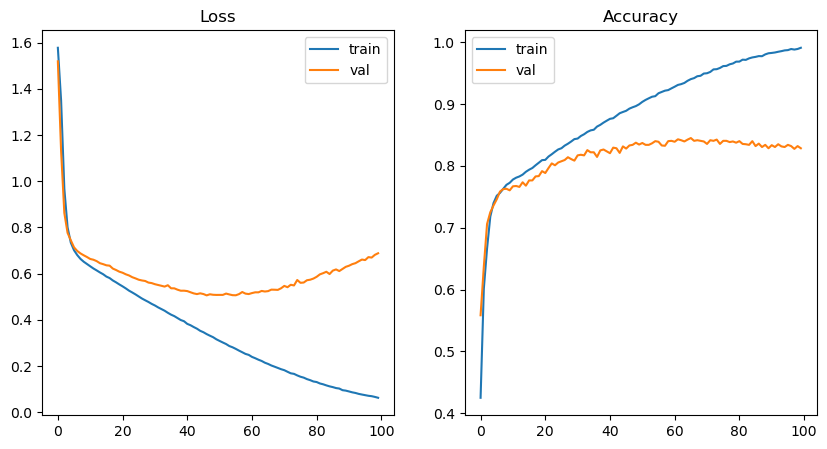

In [82]:
# Plot history graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history[0], label='train')
plt.plot(history[1], label='val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history[2], label='train')
plt.plot(history[3], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()


In [83]:
def test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(outputs.numpy())
    return all_preds, all_labels, all_probs

all_preds, all_labels, all_probs = test(model, test_loader)

Accuracy: 0.842
Precision: 0.8415240131903241
Recall: 0.842
F1: 0.8414962616039793
[[846  71  26  28  29]
 [ 79 720  60  54  87]
 [ 45  38 883  12  22]
 [ 41  56  16 878   9]
 [ 32  59  23   3 883]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.76      0.72      0.74      1000
           2       0.88      0.88      0.88      1000
           3       0.90      0.88      0.89      1000
           4       0.86      0.88      0.87      1000

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



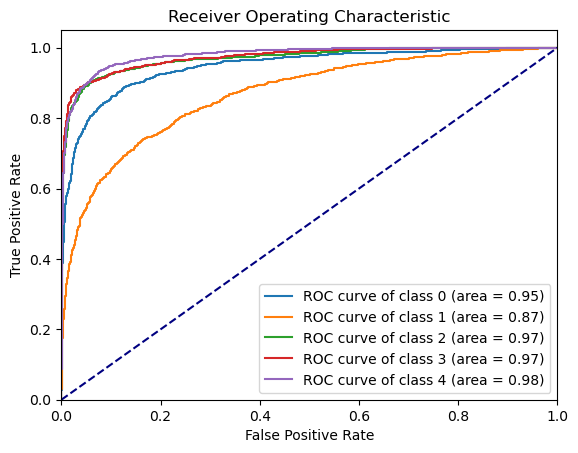

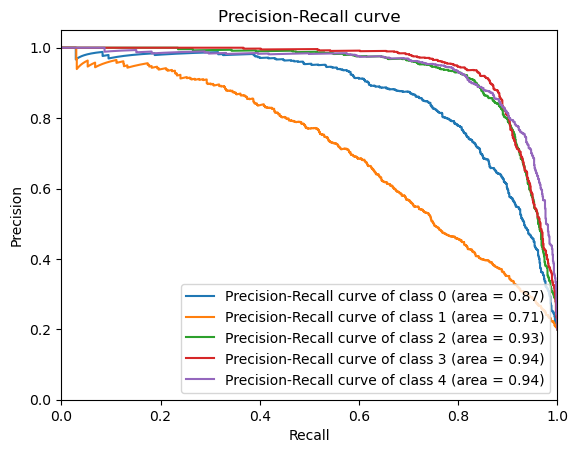

In [84]:
print('Accuracy:', accuracy_score(all_labels, all_preds))
print('Precision:', precision_score(all_labels, all_preds, average='macro'))
print('Recall:', recall_score(all_labels, all_preds, average='macro'))
print('F1:', f1_score(all_labels, all_preds, average='macro'))

cm = confusion_matrix(all_labels, all_preds)
print(cm)

print(classification_report(all_labels, all_preds))


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
n_classes = 5
all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# ROC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
    average_precision[i] = average_precision_score(all_labels_bin[:, i], all_probs[:, i])

plt.figure()

for i in range(5):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower right')
plt.show()